In [1]:
#python 2 and 3 comptibility
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import json
import io
import gzip
import base64
from astropy.io import fits
import matplotlib.pylab as plt
import pickle as pkl
import numpy as np
import sys 
import os
%matplotlib inline

PATH_TO_PROJECT = os.path.abspath(
    os.path.join(os.path.dirname('__file__'), ''))
sys.path.append(PATH_TO_PROJECT)
sys.path.append(os.path.join(PATH_TO_PROJECT,'..'))

data_path = '../AlerceDHtest/datasets/ZTF'

path = data_path+'/broker_reals.json'
with open(path, "r") as f:
        dataset = json.load(f)

# Generate camera_obs_cond["obs_conditions"]

In [2]:
def createCircularMask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

def makeGaussian(size, fwhm = 3, center=None):
    """ Make a square gaussian kernel.

    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]

    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

In [3]:
def get_zero_point(stamp, aperture_mag, exp_time=30.0):
    stamp_shape = stamp.shape
    mask = createCircularMask(stamp_shape[0], stamp_shape[1], center=np.array(stamp_shape)/2, radius=8)
    extracted_mask = np.multiply(mask, stamp)
    count_photometry = np.nansum(extracted_mask)
    if count_photometry < 0:
        return [], [], np.nan
    residual_image = stamp - extracted_mask
    zero_point = aperture_mag + 2.5*np.log10(count_photometry/exp_time)
    return zero_point, residual_image, count_photometry

In [4]:
#build dict by alert id
alerts = {}
passbands = ["g", "r", "i"]
for alert in dataset["query_result"]:
    dict_in_stamp = {'science_stamp':None, 'filter': None, 'fwhm': None, 'mjd': None, 'field': None, 'object_id': None}
    #get params to save in dict
    dict_in_stamp['filter'] = passbands[alert["candidate"]["fid"]-1]
    dict_in_stamp['fwhm'] = alert["candidate"]["fwhm"]
    dict_in_stamp['mjd'] = alert["candidate"]["jd"]
    dict_in_stamp['object_id'] = alert['objectId']
    dict_in_stamp['field'] = alert["candidate"]["field"]
    dict_in_stamp['_id'] = alert["_id"]
    #other observation conditions
    dict_in_stamp['airmass'] = 1.2# arcsen of angle of sight with respect to cenit
    dict_in_stamp['exp_time'] = 30#alert["candidate"]["exptime"]
    dict_in_stamp['limmag3'] = None
    dict_in_stamp['limmag5'] = alert["candidate"]["diffmaglim"]
    dict_in_stamp['obs_day'] = alert["candidate"]["jd"]
    dict_in_stamp['seeing'] = alert["candidate"]["fwhm"]
    #seeings shoulb be higher thn 2.0(?)
    if dict_in_stamp['seeing']<=0.5:
        dict_in_stamp['seeing'] = 2.0
    dict_in_stamp['sky_brightness'] = None #Needs to be calculated from science stamp
    #dict_in_stamp['zero_point'] =  1.0 #We dont have it but a constant is enough
    #stamps
    stamp = alert['cutoutScience']['stampData']
    stamp = base64.b64decode(stamp["$binary"].encode())
    with gzip.open(io.BytesIO(stamp), 'rb') as f:
        with fits.open(io.BytesIO(f.read())) as hdul:
            img = hdul[0].data
    dict_in_stamp['science_stamp'] = img
    
    #zero point
    aperture_mag = alert["candidate"]["magap"]
    dict_in_stamp["magap"] = aperture_mag
    zero_point, res, c = get_zero_point(img, aperture_mag)
    dict_in_stamp['zero_point'] = 24.5#zero_point
    
    stamp_id = alert["_id"]
    
    if stamp_id in alerts.keys():
        print(stamp_id)
        continue
    else:
        alerts[stamp_id] = dict_in_stamp

In [5]:
# add masked sky and sky array to dicts
n_sigmas = 4

#check if values are already in dict, to avoid second innecesarry runs
if 'masked_sky' not in alerts[list(alerts.keys())[0]].keys():
    for alert_id in alerts:
        alert = alerts[alert_id] 
        fw = alert['fwhm']
        mask = ~createCircularMask(alert['science_stamp'].shape[0], alert['science_stamp'].shape[1], radius=n_sigmas*(fw/2.35482))
        masked_sky = alert['science_stamp']*mask
        alert['masked_sky'] = masked_sky

        sky_pixels_cord = np.argwhere(mask==True)
        sky_pixels = np.array([masked_sky[cord[0],cord[1]] for cord in list(sky_pixels_cord)])
        alert['sky_pixel_values'] = sky_pixels

In [6]:
#class to filter sky without considering nans
class Sky_filter:

    def __init__(self, sky_pixels, n_sigma=2, filter_iterations=5):
        
        self.n = n_sigma
        self.sigmas = np.empty((0))
        self.n_sigmas = np.empty((0))
        self.sky_pixels = sky_pixels[np.logical_not(np.isnan(sky_pixels))]      
        
    def get_n_sigma(self, sky_pixels):
        sigma = np.std(sky_pixels)
        #print(np.mean(sky_pixels))
        #print(np.mean(sky_pixels)+sigma)
        n_sigma = np.mean(sky_pixels)+self.n*sigma
        self.sigmas = np.append(self.sigmas,np.mean(sky_pixels)+sigma)
        self.n_sigmas = np.append(self.n_sigmas,n_sigma)
        return n_sigma
    
    def filter_sky_once(self):
        last_filtered_sky = self.filtered_sky['it%i'%(len(list(self.filtered_sky.keys()))-1)]
        n_sigma = self.get_n_sigma(last_filtered_sky)
        pixels_over_sigma = np.abs(last_filtered_sky)>n_sigma
        pixels_over_std_cord = np.argwhere(pixels_over_sigma==True)
        #print(pixels_over_std_cord)
        new_filtered_sky = np.delete(last_filtered_sky, pixels_over_std_cord)
        self.filtered_sky['it%i'%len(list(self.filtered_sky.keys()))] = new_filtered_sky
        
    def iterative_filtering(self, iterations):
        #print(self.sky_pixels.shape)
        if np.isnan(self.sky_pixels).any():
            return None
            
        self.sigmas = np.empty((0))
        self.n_sigmas = np.empty((0))
        self.filtered_sky = {'it0':self.sky_pixels}
        for i in range(iterations):
            self.filter_sky_once()
        return self.filtered_sky

    def check_availability(self, array, idx):
        array = np.array(array)
        if array.shape[0]-1<idx:
            check_nans = self.iterative_filtering(idx+1)
        if check_nans is None:
            raise ValueError('nans in sky pixels')
            
    def plot_array(self, array):
        array = np.array(array)
        x = np.arange(0, array.shape[0])
        plt.plot(x,array)
            
    def plot_filtered_sky_sigmas(self, idx=0, x_pos=32, y_pos=32):
        self.check_availability(self.n_sigmas, idx)
        
        #plt.figure(figsize=(12,12))
        line = np.arange(0,self.sky_pixels.shape[0])
        n_sigma_line = np.full(self.sky_pixels.shape[0], self.n_sigmas[idx])
        mean = np.full(self.sky_pixels.shape[0], np.mean(self.sky_pixels))
        plt.scatter(line, self.sky_pixels)
        #plt.lim(np.min(self.sky_pixels),np.max(self.sky_pixels))
        plt.plot(line, n_sigma_line, color='black', label='sigma')
        plt.plot(line, mean, '--', color='black', label='mean')
        #print(self.sky_pixels)
        #print(self.sky_pixels.shape)
        plt.title(r'non-filtered $\sigma$[%f], max: %f'%(self.n_sigmas[idx].round(decimals=3), np.max(self.sky_pixels)))
        plt.legend()
        plt.show()

        filtered_sky = self.filtered_sky['it%i'%idx]
        line = np.arange(0,filtered_sky.shape[0])
        n_sigma_line = np.full(filtered_sky.shape[0], self.n_sigmas[idx])
        mean = np.full(filtered_sky.shape[0], np.mean(filtered_sky))
        plt.scatter(line, filtered_sky)
        plt.plot(line, n_sigma_line, color='black', label='sigma')
        plt.plot(line, mean, '--', color='black', label='mean')
        plt.title(r'filtered $\sigma$['+str(idx)+r']: '+str(self.n_sigmas[idx].round(decimals=3)))
        plt.legend()
        plt.show()
        
        self.plot_array(self.n_sigmas)
        plt.title(r'$\sigma$´s progretions')
        plt.show()

In [7]:
# add filtered sky (after filter_iterations iterations) to dict
filter_iterations = 10

#check if values are already in dict, to avoid second innecesarry runs
if 'filtered_sky_pixel_values' not in alerts[list(alerts.keys())[0]].keys():
    #i=0
    for alert_id in alerts:
        #print(i)
        #i+=1
        alert = alerts[alert_id] 
        sky_values = alert['sky_pixel_values']
        sky_filter = Sky_filter(sky_values)
        filtered_sky = sky_filter.iterative_filtering(iterations=filter_iterations)
        #get last iteration filtered sky
        last_iteration_filtered_sky = filtered_sky[list(filtered_sky.keys())[-1]]
        mean_sky_value = np.mean(last_iteration_filtered_sky)
        #add data to dict
        alert['filtered_sky_pixel_values'] = last_iteration_filtered_sky
        alert['sky_value'] = mean_sky_value

In [8]:
alerts[alert_id].keys()

dict_keys(['science_stamp', 'filter', 'fwhm', 'mjd', 'field', 'object_id', '_id', 'airmass', 'exp_time', 'limmag3', 'limmag5', 'obs_day', 'seeing', 'sky_brightness', 'magap', 'zero_point', 'masked_sky', 'sky_pixel_values', 'filtered_sky_pixel_values', 'sky_value'])

In [9]:
# Filter alerts that have less than N_ALERTS_IN_OBJ_ID
#all OBJ_ID
all_obj_id = [alerts[alert_id]['object_id'] for alert_id in alerts]

In [10]:
#count mjds and generate dict mjd/count_mjd
#TODO: add frequency to dict
from collections import Counter
object_id_group_dict = Counter(all_obj_id)
#print(Counter(all_obj_id).keys()) # equals to list(set(words))
#print(Counter(all_obj_id).values()) # counts the elements' frequency
#plt.hist(Counter(all_obj_id).values(), bins=100)
#plt.show()

In [11]:
#filter alerts that have less than N_ALERTS_IN_OBJ_ID freq
N_ALERTS_IN_OBJ_ID = 20
filtered_alerts = {}

for alert_id in alerts:
    alert_obj_id = alerts[alert_id]['object_id']
    if object_id_group_dict[alert_obj_id]>=N_ALERTS_IN_OBJ_ID:
        filtered_alerts[alert_id] = alerts[alert_id]
        

In [12]:
#visualize channels
#for alert in filtered_alerts:
#    print(filtered_alerts[alert]['filter'])

In [13]:
## Group alerts by field (every object is considered as a diferrent field)
all_objectsId = [filtered_alerts[alert_id]['object_id'] for alert_id in filtered_alerts]
objectId_uniques = np.unique(all_objectsId)

In [14]:
filtered_alerts[list(filtered_alerts.keys())[0]].keys()

dict_keys(['science_stamp', 'filter', 'fwhm', 'mjd', 'field', 'object_id', '_id', 'airmass', 'exp_time', 'limmag3', 'limmag5', 'obs_day', 'seeing', 'sky_brightness', 'magap', 'zero_point', 'masked_sky', 'sky_pixel_values', 'filtered_sky_pixel_values', 'sky_value'])

In [15]:
#name field
field_objectId_dict = {}
for i, objectId in enumerate(objectId_uniques):
    field_objectId_dict['Field%s' % str(i+1).zfill(2)] = objectId

In [16]:
#create dict of fields as in https://github.com/rodrigcd/HiTS_simulations, but with the extra parameter calculed above
camera_obs_cond_non_filtered = {}
camera_obs_cond_non_filtered["obs_conditions"] = {}
for field in field_objectId_dict.keys():
    camera_obs_cond_non_filtered["obs_conditions"][field] = []
    appended_alert_count = 0
    for alert_id in filtered_alerts:
        if filtered_alerts[alert_id]['object_id'] == field_objectId_dict[field]:
            filtered_alerts[alert_id]['epoch'] = appended_alert_count+1
            filtered_alerts[alert_id]['sky_brightness'] = filtered_alerts[alert_id]['sky_value']
            camera_obs_cond_non_filtered["obs_conditions"][field].append(filtered_alerts[alert_id])
            appended_alert_count +=1

In [17]:
#Remove extra keys, and leave the ones for rodrigo
camera_obs_cond = {}
camera_obs_cond["obs_conditions"] = {}

for field in camera_obs_cond_non_filtered["obs_conditions"].keys():
    camera_obs_cond["obs_conditions"][field] = []
    for alert in camera_obs_cond_non_filtered["obs_conditions"][field]:
        aux_alert = {
            'airmass': alert['airmass'],
            'epoch': alert['epoch'],
            'exp_time': alert['exp_time'],
            'filter': alert['filter'],
            'limmag3': alert['limmag3'],
            'limmag5': alert['limmag5'],
            'obs_day': alert['obs_day'], 
            'seeing': alert['seeing'],
            'sky_brightness': alert['sky_brightness'],
            'zero_point': alert['zero_point']
        }
        camera_obs_cond["obs_conditions"][field].append(aux_alert)

# Generate camera_obs_cond['psf']

In [18]:
psf_data_dict={"g":{}, "r":{}, "i":{}}
for channel in psf_data_dict.keys():
    psf_data_dict[channel]={"n_alerts":{}, "stamp":{}, "jd":{}, 'mean_stamps':{}, 'mean_stamp_masked':{}}

In [19]:
#group alerts by channel and fwhm
all_fwhm = []
filters_ls = list(psf_data_dict.keys())
for alert in dataset["query_result"]:
    fwhm = alert["candidate"]["fwhm"]
    jd = alert["candidate"]["jd"]
    fid = alert["candidate"]["fid"]
    all_fwhm.append(fwhm)
    stamp = alert['cutoutDifference']['stampData']
    stamp = base64.b64decode(stamp["$binary"].encode())
    with gzip.open(io.BytesIO(stamp), 'rb') as f:
        with fits.open(io.BytesIO(f.read())) as hdul:
            img = hdul[0].data

    if fwhm in psf_data_dict[filters_ls[fid-1]]['n_alerts'].keys():
        psf_data_dict[filters_ls[fid-1]]['n_alerts'][fwhm] += 1
        psf_data_dict[filters_ls[fid-1]]['stamp'][fwhm].append(img)
        psf_data_dict[filters_ls[fid-1]]['jd'][fwhm].append(jd)
    else:
        psf_data_dict[filters_ls[fid-1]]['n_alerts'][fwhm] = 1
        psf_data_dict[filters_ls[fid-1]]['stamp'][fwhm] = [img,]
        psf_data_dict[filters_ls[fid-1]]['jd'][fwhm] = [jd,]

In [20]:
#calculate mean stamp and masked mean
n_sigmas = 2.5#4
for channel in filters_ls:
    n_alerts = psf_data_dict[channel]['n_alerts']
    stamp_dict = psf_data_dict[channel]['stamp']
    for j, fw in enumerate(n_alerts.keys()):
        if fw>1 and fw<12 and n_alerts[fw] >= 10:
            aux_stamp_dict = stamp_dict[fw][:]
            for i, s in enumerate(aux_stamp_dict):
                aux_stamp_dict[i] = np.nan_to_num(s)[21:42, 21:42]
                aux_stamp_dict[i] = aux_stamp_dict[i]/np.sum(aux_stamp_dict[i])
            aux_stamp_dict = np.stack(aux_stamp_dict)
            #print(aux_stamp_dict.shape)
            psf = np.mean(aux_stamp_dict, axis=0)
            psf = psf/np.sum(psf)
            
            #mask
            #mask = createCircularMask(21,21,radius=n_sigmas*(fw/2.35482))
            mask = makeGaussian(21, fwhm = fw*n_sigmas, center=None)
            masked_psf = mask*psf
            masked_psf = masked_psf/np.sum(masked_psf)
            
            #append mean stamp
            psf_data_dict[channel]['mean_stamps'][fw] = psf
            psf_data_dict[channel]['mean_stamp_masked'][fw] = masked_psf
            #if fw in psf_data_dict[channel]['mean_stamps'].keys():
                #psf_data_dict[channel]['mean_stamps'][fw].append(psf)
            #else:
                #psf_data_dict[channel]['mean_stamps'][fw] = [psf,]

            #append mask
            #if fw in psf_data_dict[channel]['mean_stamp_masked'].keys():
            #    psf_data_dict[channel]['mean_stamp_masked'][fw].append(masked_psf)
            #else:
                #psf_data_dict[channel]['mean_stamp_masked'][fw] = [masked_psf,]

In [21]:
# Generate psf's as in https://github.com/rodrigcd/HiTS_simulations
print(psf_data_dict.keys())
print(psf_data_dict[list(psf_data_dict.keys())[0]].keys())

# mix psf's by channels
PSFs_TO_CHOOSE_KEY = "mean_stamp_masked"
#camera_obs_cond = {}
camera_obs_cond["psf"] = np.empty(list(psf_data_dict[list(psf_data_dict.keys())[0]][PSFs_TO_CHOOSE_KEY][list(psf_data_dict[list(psf_data_dict.keys())[0]][PSFs_TO_CHOOSE_KEY].keys())[0]].shape)+[0])

for channel in psf_data_dict.keys():
    for fwhm in psf_data_dict[channel][PSFs_TO_CHOOSE_KEY].keys():
        camera_obs_cond["psf"] = np.concatenate([camera_obs_cond["psf"], psf_data_dict[channel][PSFs_TO_CHOOSE_KEY][fwhm][...,np.newaxis]], axis=-1)
        
camera_obs_cond["psf"].shape

dict_keys(['g', 'r', 'i'])
dict_keys(['n_alerts', 'stamp', 'jd', 'mean_stamps', 'mean_stamp_masked'])


(21, 21, 240)

In [22]:
# Manually filter outbad psfs
psfs = camera_obs_cond["psf"]
#for i in range(psfs.shape[-1]):
#    print(i)
#    plt.imshow(psfs[...,i])
#    plt.colorbar()
#    plt.show()
psfs.shape

(21, 21, 240)

In [26]:
#filter out psf with large negative values
psfs_filtered = []#np.empty(list(psf_data_dict[list(psf_data_dict.keys())[0]][PSFs_TO_CHOOSE_KEY][list(psf_data_dict[list(psf_data_dict.keys())[0]][PSFs_TO_CHOOSE_KEY].keys())[0]].shape)+[0])
print(psfs.shape)
for i in range(psfs.shape[-1]):
    #print(np.amin(psfs[...,i]))
    if np.amin(psfs[...,i])<=-0.0099:#i #in #filter_out:
        continue
    psfs_filtered.append(psfs[...,i])
psfs_filtered = np.stack(psfs_filtered, axis=2)

#replace negative values with neighbours mean
#given a image replace values below threshold with mean of neghbours.
psfs = camera_obs_cond["psf"]
def NN_threshold_ignoring_negative_mask(image, thr, mask_size=3):
    pad_size = mask_size//2
    npad = ((pad_size, pad_size), (pad_size, pad_size))
    aux_padded_image = np.pad(image, pad_width=npad, mode='constant', constant_values=0)
    x, y = image.shape
    for i in range(x):
        i_in_aux_image = i+pad_size
        for j in range(y):
            j_in_aux_image = j+pad_size
            if image[i,j] < thr:
                neighbors = aux_padded_image[i_in_aux_image-pad_size:i_in_aux_image+pad_size+1,j_in_aux_image-pad_size:j_in_aux_image+pad_size+1]
                positive_mean = np.mean(neighbors[neighbors>=thr])
                if np.isnan(positive_mean):
                    print('image(%i,%i): %.16f mask_size %i\n %s , ' % (
                        i, j, image[i,j], mask_size, str(neighbors)))
                    continue 
                else:
                    image[i,j] = positive_mean
    return image

def NN_threshold(image, thr):
    image_to_return = np.copy(image)
    mask_size  = 3
    while (image_to_return>=thr).all() != True:
        image_to_return = NN_threshold_ignoring_negative_mask(image_to_return, thr, mask_size)
        mask_size += 2
    return image_to_return


def NN_threshold_array(data_array):
    for i in range(data_array.shape[-1]):
        print('\nPSF %i' % i)
        data_array[...,i] = NN_threshold(data_array[...,i], thr=0)
    return data_array

psfs_filtered_and_positive = NN_threshold_array(psfs_filtered)

print(psfs_filtered_and_positive.shape)
    
#camera_obs_cond["psf"] = psfs_filtered_and_positive
#print(camera_obs_cond["psf"].shape)
        


(21, 21, 240)

PSF 0

PSF 1
image(1,13): -0.0000056577422694 mask_size 3
 [[-5.90051242e-06 -7.94427438e-06 -1.04905506e-05]
 [-7.86119804e-05 -5.65774227e-06 -7.52349431e-06]
 [-1.41196109e-04 -2.90341452e-05 -5.90958896e-05]] , 
image(1,14): -0.0000075234943081 mask_size 3
 [[-7.94427438e-06 -1.04905506e-05 -5.16541223e-06]
 [-5.65774227e-06 -7.52349431e-06 -1.99806795e-06]
 [-2.90341452e-05 -5.90958896e-05 -2.97381230e-05]] , 

PSF 2

PSF 3
image(17,15): -0.0000391997048802 mask_size 3
 [[-3.62543244e-05 -5.46810088e-06 -1.02838780e-05]
 [-3.80378854e-05 -3.91997049e-05 -2.69901351e-05]
 [-2.08362337e-05 -1.02664948e-05 -2.35598944e-06]] , 

PSF 4
image(2,7): -0.0000219663618877 mask_size 3
 [[-6.72111229e-06 -5.81887923e-06 -4.76967093e-06]
 [-2.23416790e-05 -2.19663619e-05 -1.87566282e-05]
 [-1.90320832e-05 -8.71933881e-05 -4.06563954e-05]] , 
image(2,8): -0.0000187566281914 mask_size 3
 [[-5.81887923e-06 -4.76967093e-06 -1.13795108e-05]
 [-2.19663619e-05 -1.87566282e-05 -2.243544

/home/esteban/anaconda3/envs/tf/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/esteban/anaconda3/envs/tf/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



PSF 29

PSF 30

PSF 31
image(6,8): -0.0002902897464704 mask_size 3
 [[-0.00023587 -0.00046646 -0.0003786 ]
 [-0.00019033 -0.00029029 -0.00061036]
 [-0.00160835 -0.00324117 -0.00119388]] , 
image(11,2): -0.0001494592399028 mask_size 3
 [[-8.56109728e-06 -1.42654548e-04 -1.72387093e-04]
 [-1.09069914e-05 -1.49459240e-04 -1.18874499e-04]
 [-8.98948641e-06 -2.14851214e-05 -8.68675789e-06]] , 

PSF 32
image(11,1): -0.0000149153349390 mask_size 3
 [[-7.06242156e-06 -1.55788391e-05 -3.68488371e-05]
 [-3.28541674e-06 -1.49153349e-05 -1.25230262e-04]
 [-8.89868870e-07 -2.90261352e-05 -9.96470269e-07]] , 
image(12,1): -0.0000290261352462 mask_size 3
 [[-3.28541674e-06 -1.49153349e-05 -1.25230262e-04]
 [-8.89868870e-07 -2.90261352e-05 -9.96470269e-07]
 [-2.48090633e-06 -9.26541636e-06 -2.74331015e-05]] , 

PSF 33
image(10,1): -0.0000528944916785 mask_size 3
 [[-1.14151531e-05 -1.31574035e-04 -3.25670213e-05]
 [-6.90260206e-06 -5.28944917e-05 -1.70327780e-04]
 [-2.34544571e-05 -6.00503723e-05 -5.

PSF 91

PSF 92
image(4,4): -0.0000037894122958 mask_size 3
 [[-2.03255510e-08 -1.17846033e-07 -3.42532135e-07]
 [-5.54855202e-07 -3.78941230e-06 -4.07215915e-06]
 [-3.74057454e-06 -9.08406171e-06 -8.30435230e-06]] , 
image(4,5): -0.0000040721591503 mask_size 3
 [[-1.17846033e-07 -3.42532135e-07 -1.14115011e-07]
 [-3.78941230e-06 -4.07215915e-06 -8.38510090e-06]
 [-9.08406171e-06 -8.30435230e-06 -5.33080074e-05]] , 

PSF 93

PSF 94
image(18,12): -0.0000119030465217 mask_size 3
 [[-5.52199152e-05 -5.86568737e-08 -1.97753038e-04]
 [-3.19659390e-05 -1.19030465e-05 -2.35299411e-05]
 [-1.33486030e-05 -3.91148441e-05 -4.58329533e-06]] , 
image(18,13): -0.0000235299411465 mask_size 3
 [[-5.86568737e-08 -1.97753038e-04 -3.17955806e-05]
 [-1.19030465e-05 -2.35299411e-05 -2.85289554e-05]
 [-3.91148441e-05 -4.58329533e-06 -7.63046018e-06]] , 

PSF 95
image(1,19): -0.0000000094067913 mask_size 3
 [[-3.08589591e-09 -3.36280773e-10 -5.57234405e-11]
 [-1.78901303e-08 -9.40679135e-09 -7.79276798e-10]
 

 [-4.58230387e-05 -2.07006153e-05 -8.79218373e-06]] , 
image(16,17): -0.0000458230386544 mask_size 3
 [[-1.92221592e-05 -4.60975852e-05 -2.66436895e-05]
 [-1.86134538e-05 -4.58230387e-05 -2.07006153e-05]
 [-1.43077639e-05 -1.50741193e-05 -2.01898552e-06]] , 
image(16,18): -0.0000207006153081 mask_size 3
 [[-4.60975852e-05 -2.66436895e-05 -9.00776731e-06]
 [-4.58230387e-05 -2.07006153e-05 -8.79218373e-06]
 [-1.50741193e-05 -2.01898552e-06 -1.80956242e-06]] , 

PSF 154

PSF 155
image(13,16): -0.0000230320811735 mask_size 3
 [[-3.27023127e-06 -4.56420660e-05 -1.79626371e-05]
 [-3.03336338e-04 -2.30320812e-05 -7.53768846e-06]
 [-8.61857089e-05 -3.65597633e-05 -2.56088097e-05]] , 

PSF 156

PSF 157
image(16,2): -0.0000075494471911 mask_size 3
 [[-6.28257652e-06 -1.03808779e-05 -4.38977828e-05]
 [-8.56841282e-07 -7.54944719e-06 -1.89660215e-05]
 [-2.10872472e-07 -2.75307471e-06 -3.59194926e-06]] , 

PSF 158
image(15,5): -0.0000451152885824 mask_size 3
 [[-1.35847395e-04 -1.78376251e-04 -4.96

image(7,5): -0.0018367639325064 mask_size 3
 [[-9.89744748e-05 -6.99682571e-05 -1.80205238e-03]
 [-4.24032153e-04 -1.83676393e-03 -1.05122686e-03]
 [-2.33077133e-04 -1.31189302e-03 -3.94927874e-04]] , 

PSF 214

PSF 215
image(19,18): -0.0000000007783419 mask_size 3
 [[-5.89899689e-09 -1.19528353e-09 -2.72225105e-10]
 [-2.16837409e-10 -7.78341894e-10 -6.23137184e-11]
 [-3.27520272e-10 -3.45980709e-11 -6.98102302e-12]] , 
(21, 21, 216)


# Generate camera_obs_cond["camera_params"]

In [89]:
camera_obs_cond["camera_params"] = {}
camera_obs_cond["camera_params"]["CCD01"] = {'ccd_num': 1,
                                             'gain': 5.0, #[e-/ADU]
                                             'read_noise': 11.1, #[e-]
                                             'saturation': 350000.0, #[ADU]
                                             'pixel_scale': 1, #[arcsec/pixel]
                                             'zp_g': 25.399156, #camera zero point not used
                                             'zp_i': 25.313254,
                                             'zp_r': 25.474396,
                                             'zp_u': 23.546145}

In [90]:
pkl.dump(camera_obs_cond, open('generated_data/ztf_conditions_v3.pkl', 'wb'), protocol=2)

In [91]:
#plt.imshow(camera_obs_cond['psf'][...,0])
#plt.colorbar()

In [92]:
camera_obs_cond['psf'][...,0].sum()

0.9999999999999998

index 0, min values -0.002450


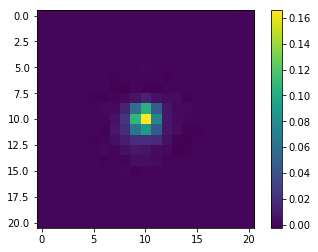

index 1, min values -0.003234


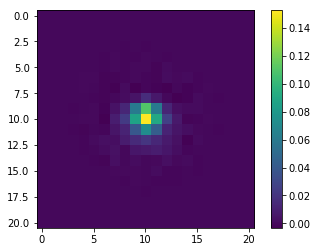

index 2, min values -0.006601


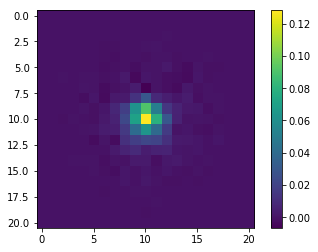

index 3, min values -0.004955


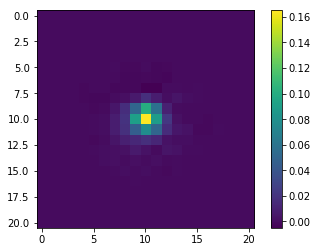

index 4, min values -0.002643


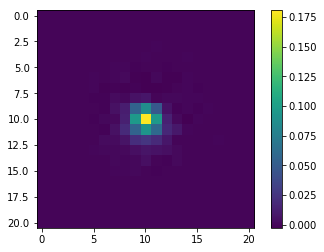

index 5, min values -0.002549


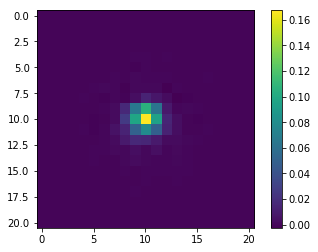

index 6, min values -0.001906


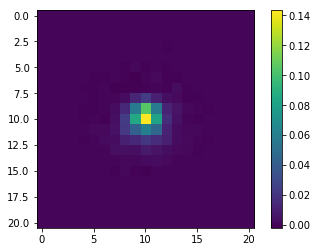

index 7, min values -0.004018


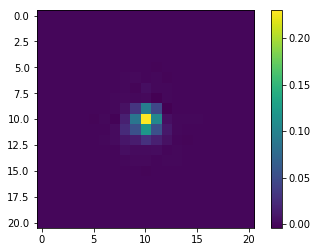

index 8, min values -0.001861


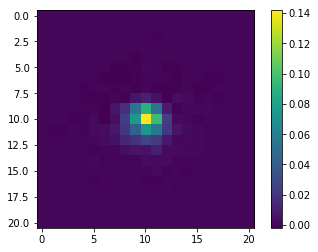

index 9, min values -0.008188


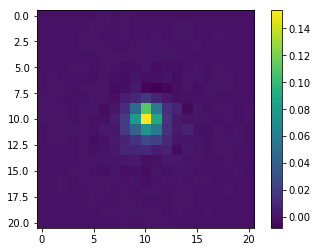

index 10, min values -0.001173


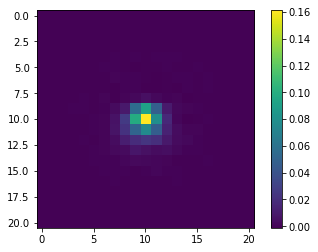

index 11, min values -0.003394


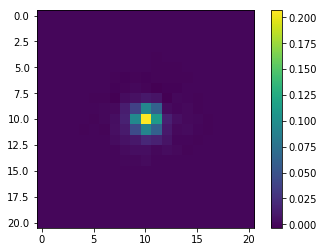

index 12, min values -0.001213


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [93]:
#visualice filtered psfs
psfs = camera_obs_cond["psf"]
for i in range(psfs.shape[-1]):
    print('index %i, min values %f' % (i, np.min(psfs[...,i])))
    plt.imshow(psfs[...,i])
    plt.colorbar()
    plt.show()
psfs.shape
psfs.shape

index 0, min values 0.000000


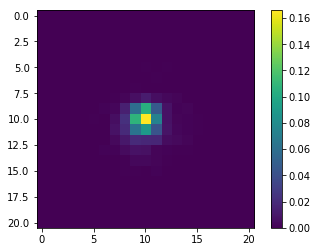

index 1, min values 0.000000


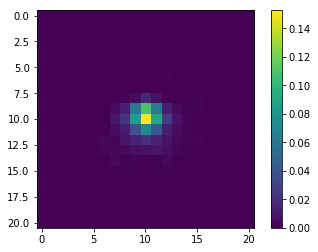

index 2, min values 0.000000


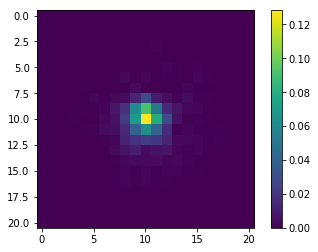

index 3, min values 0.000000


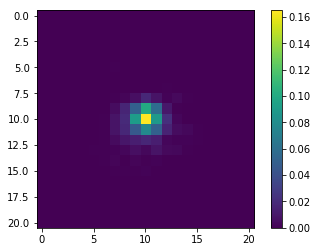

index 4, min values 0.000000


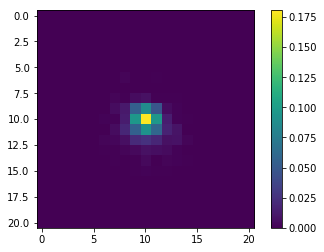

index 5, min values 0.000000


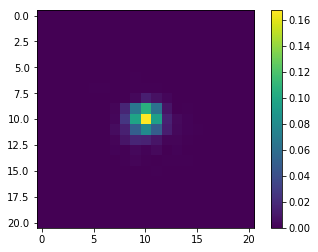

index 6, min values 0.000000


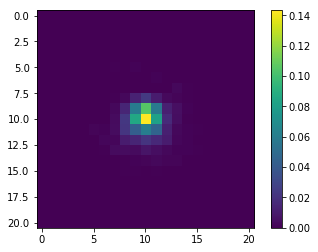

index 7, min values 0.000000


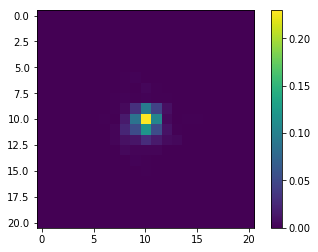

index 8, min values 0.000000


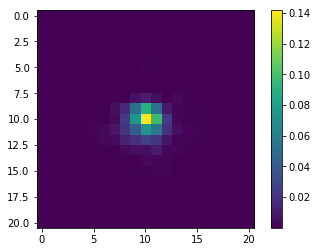

index 9, min values 0.000000


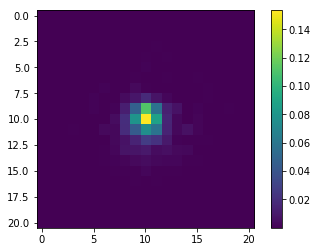

index 10, min values 0.000000


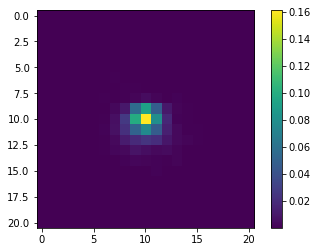

index 11, min values 0.000000


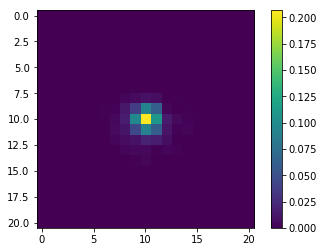

index 12, min values 0.000000


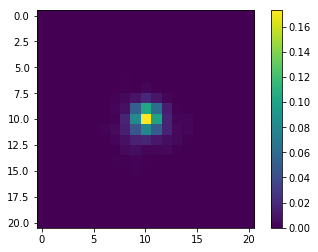

index 13, min values 0.000000


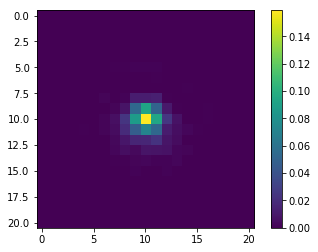

index 14, min values 0.000000


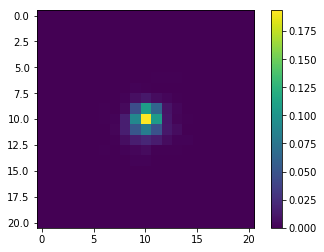

index 15, min values 0.000000


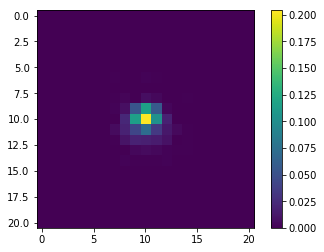

index 16, min values 0.000000


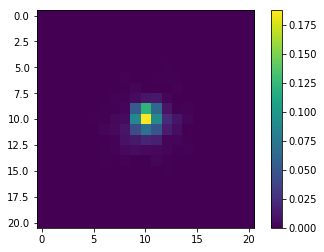

index 17, min values 0.000000


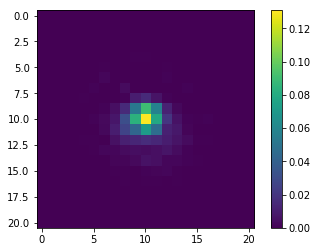

index 18, min values 0.000000


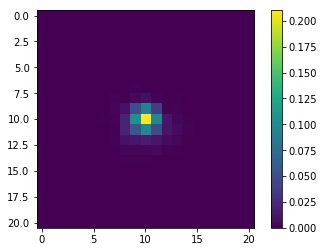

index 19, min values 0.000000


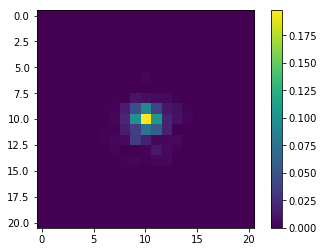

index 20, min values 0.000000


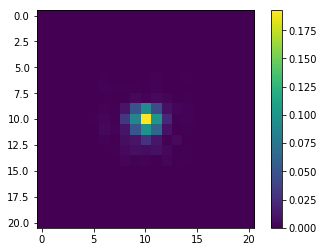

index 21, min values 0.000000


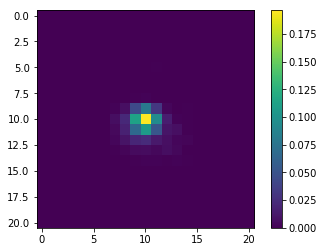

index 22, min values 0.000000


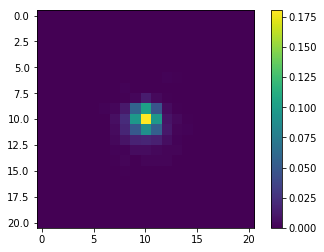

index 23, min values 0.000000


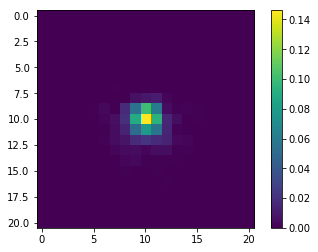

index 24, min values 0.000000


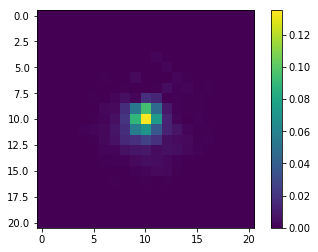

index 25, min values 0.000000


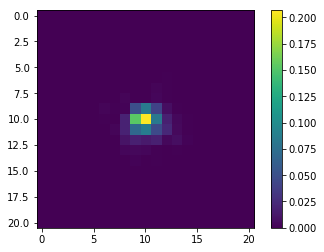

index 26, min values 0.000000


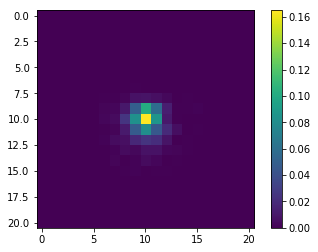

index 27, min values 0.000000


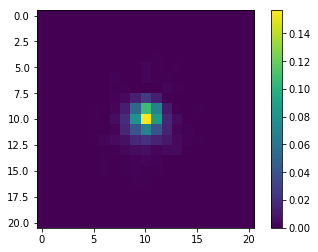

index 28, min values 0.000000


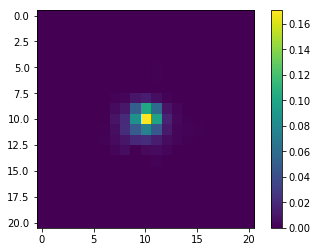

index 29, min values 0.000000


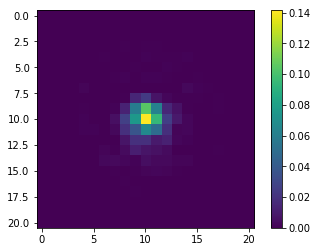

index 30, min values 0.000000


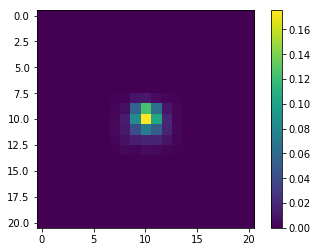

index 31, min values 0.000000


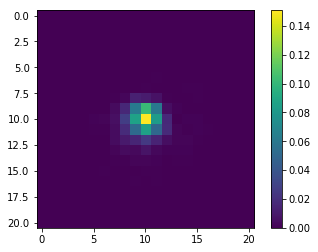

index 32, min values 0.000000


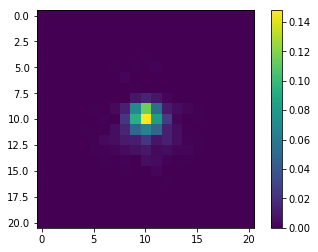

index 33, min values 0.000000


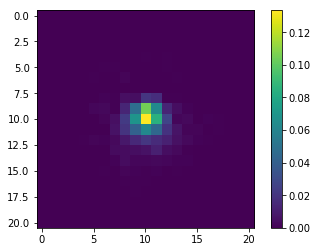

index 34, min values 0.000000


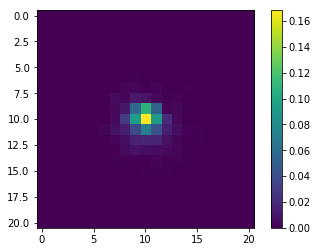

index 35, min values 0.000000


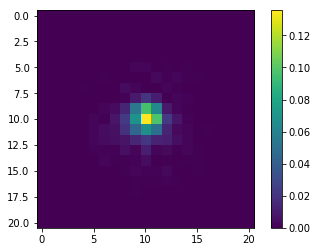

index 36, min values 0.000000


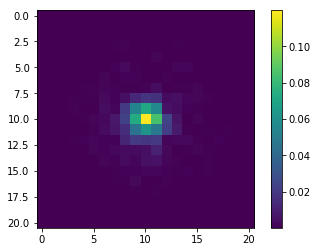

index 37, min values 0.000000


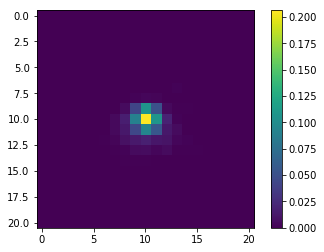

index 38, min values 0.000000


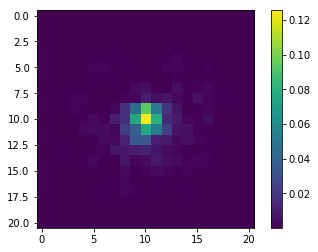

index 39, min values 0.000000


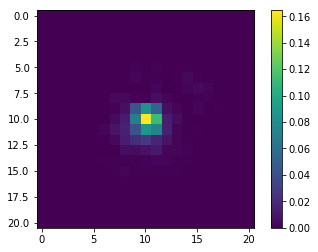

index 40, min values 0.000000


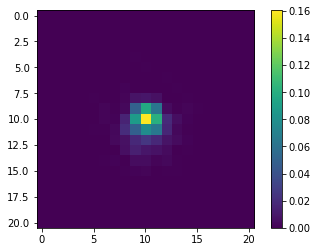

index 41, min values 0.000000


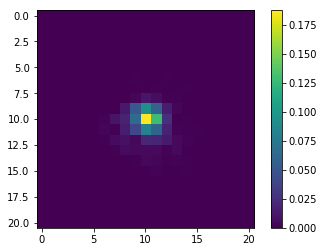

index 42, min values 0.000000


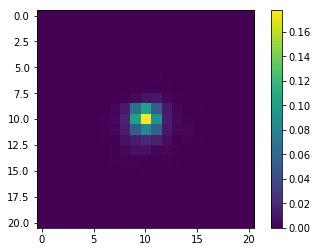

index 43, min values 0.000000


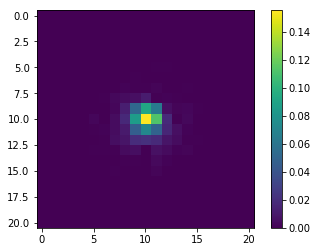

index 44, min values 0.000000


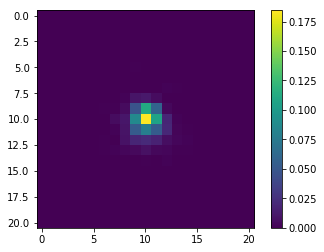

index 45, min values 0.000000


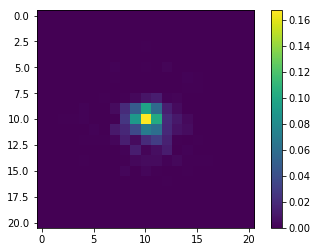

index 46, min values 0.000000


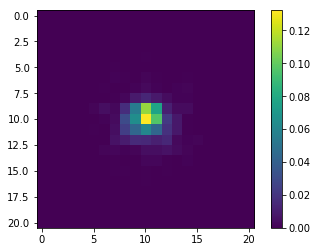

index 47, min values 0.000000


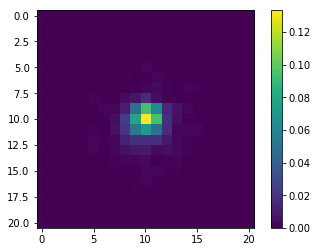

index 48, min values 0.000000


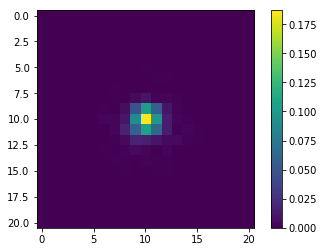

index 49, min values 0.000000


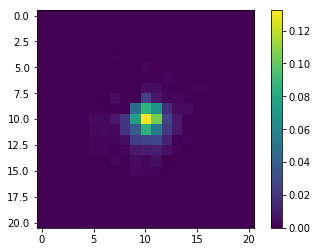

index 50, min values 0.000000


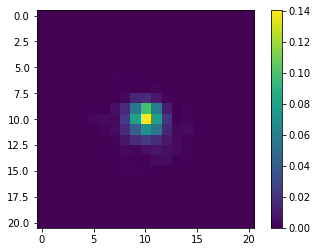

index 51, min values 0.000000


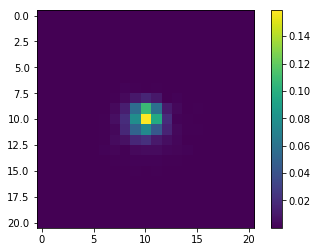

index 52, min values 0.000000


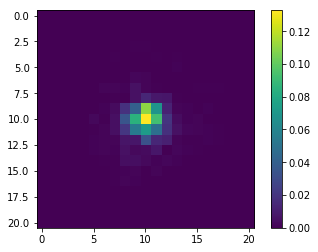

index 53, min values 0.000000


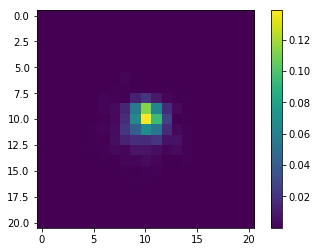

index 54, min values 0.000000


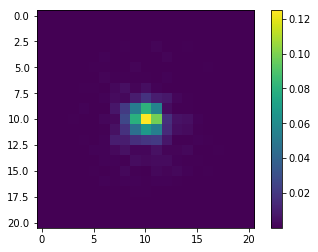

index 55, min values 0.000000


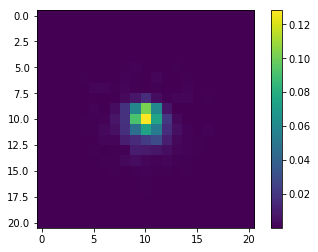

index 56, min values 0.000000


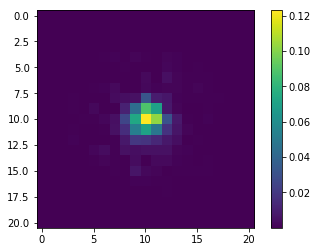

index 57, min values 0.000000


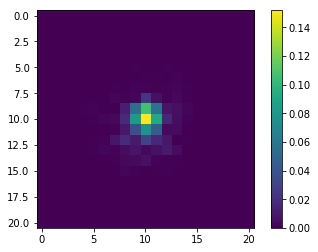

index 58, min values 0.000000


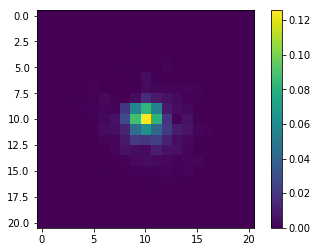

index 59, min values 0.000000


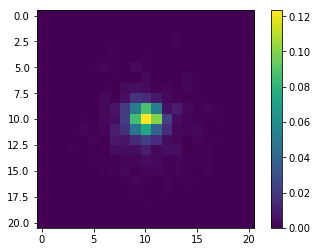

index 60, min values 0.000000


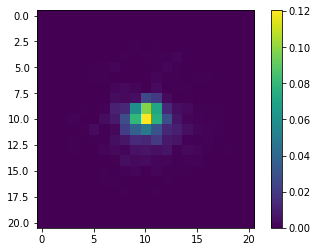

index 61, min values 0.000000


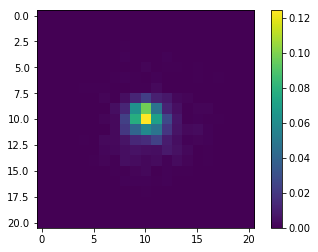

index 62, min values 0.000000


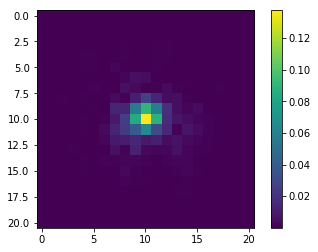

index 63, min values 0.000000


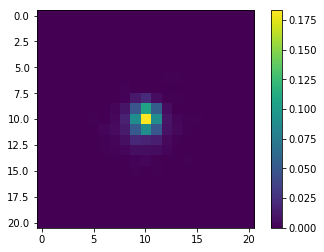

index 64, min values 0.000000


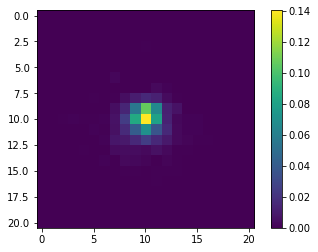

index 65, min values 0.000000


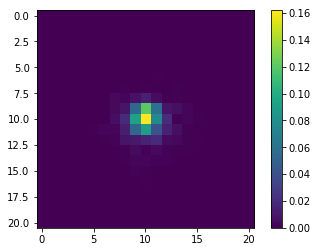

index 66, min values 0.000000


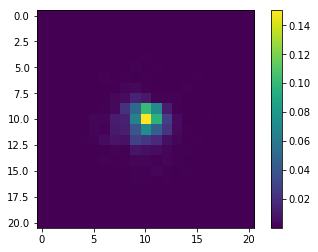

index 67, min values 0.000000


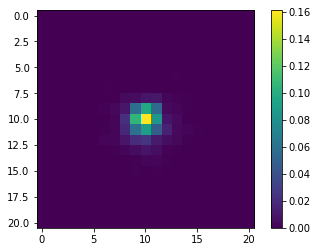

index 68, min values 0.000000


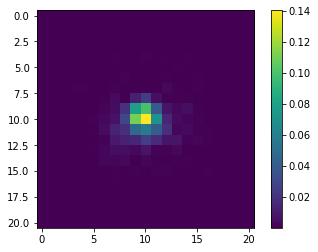

index 69, min values 0.000000


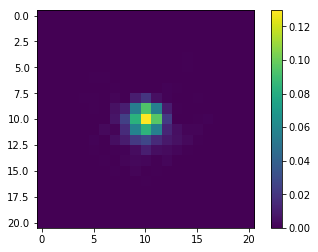

index 70, min values 0.000000


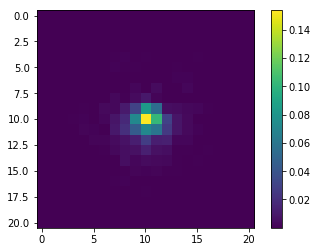

index 71, min values 0.000000


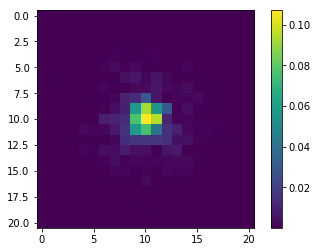

index 72, min values 0.000000


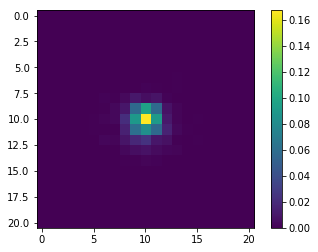

index 73, min values 0.000000


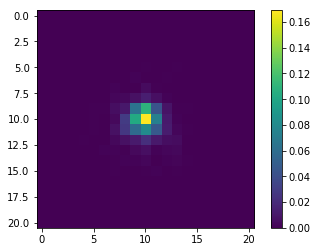

index 74, min values 0.000000


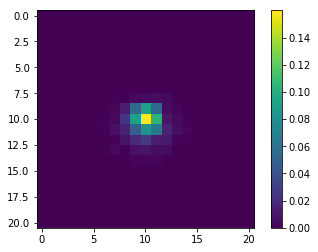

index 75, min values 0.000000


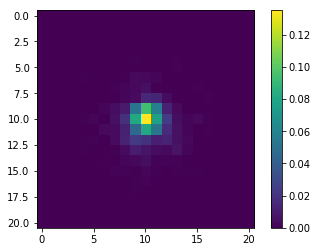

index 76, min values 0.000000


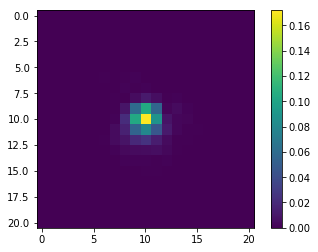

index 77, min values 0.000000


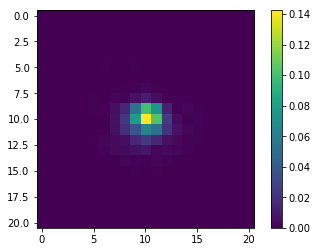

index 78, min values 0.000000


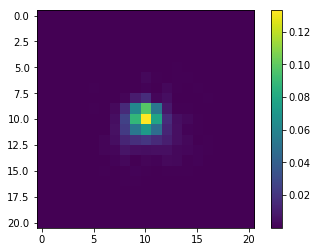

index 79, min values 0.000000


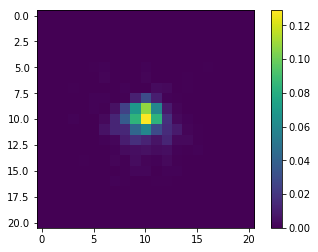

index 80, min values 0.000000


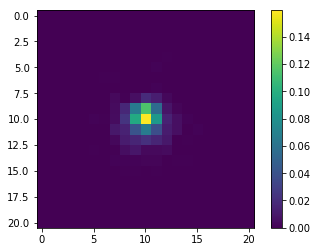

index 81, min values 0.000000


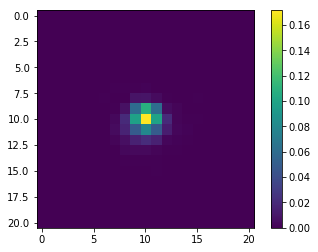

index 82, min values 0.000000


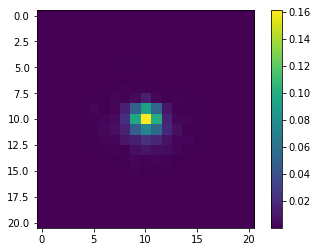

index 83, min values 0.000000


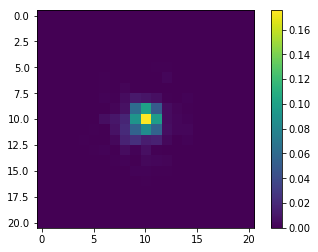

index 84, min values 0.000000


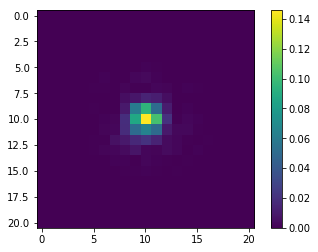

index 85, min values 0.000000


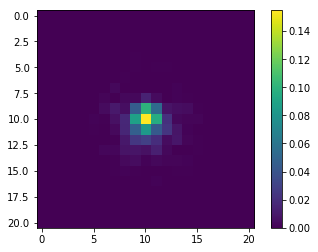

index 86, min values 0.000000


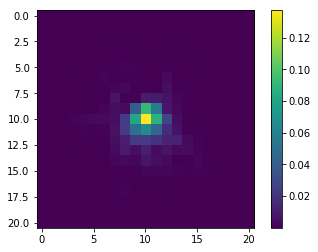

index 87, min values 0.000000


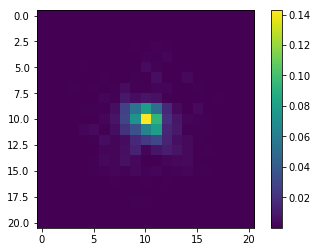

index 88, min values 0.000000


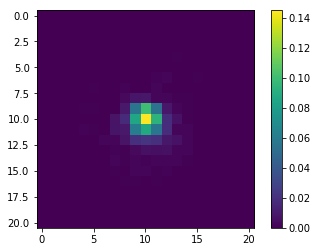

index 89, min values 0.000000


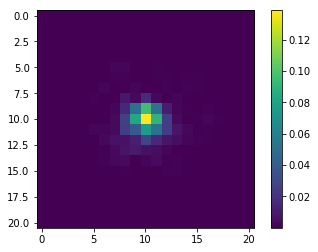

index 90, min values 0.000000


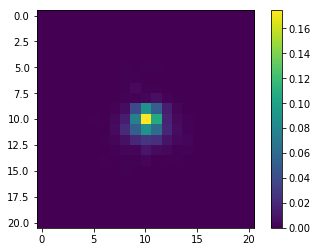

index 91, min values 0.000000


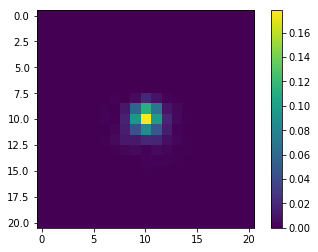

index 92, min values 0.000000


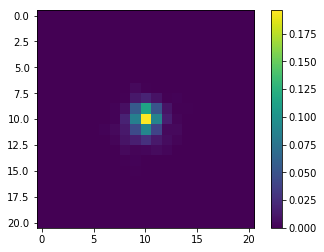

index 93, min values 0.000000


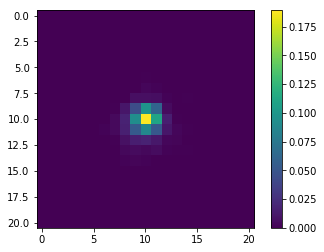

index 94, min values 0.000000


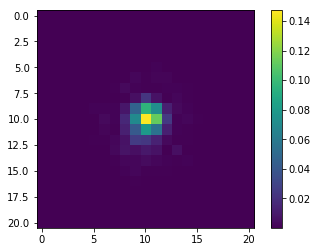

index 95, min values 0.000000


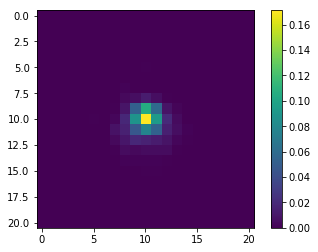

index 96, min values 0.000000


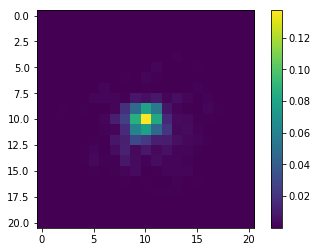

index 97, min values 0.000000


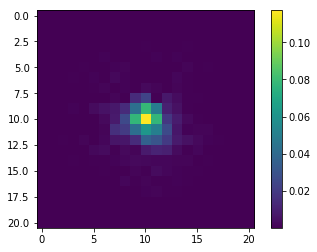

index 98, min values 0.000000


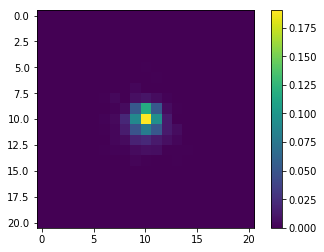

index 99, min values 0.000000


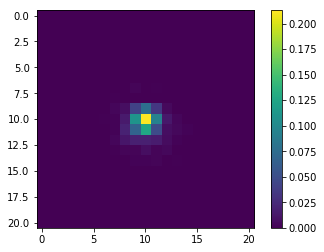

index 100, min values 0.000000


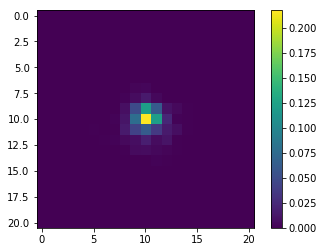

index 101, min values 0.000000


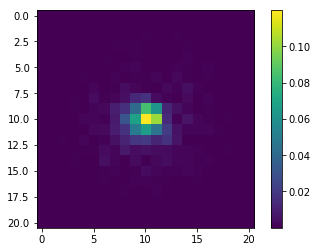

index 102, min values 0.000000


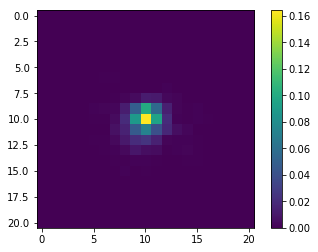

index 103, min values 0.000000


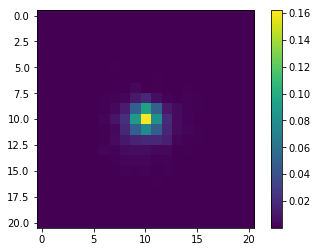

index 104, min values 0.000000


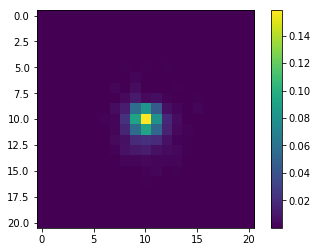

index 105, min values 0.000000


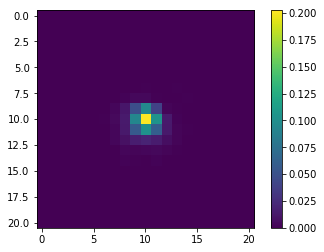

index 106, min values 0.000000


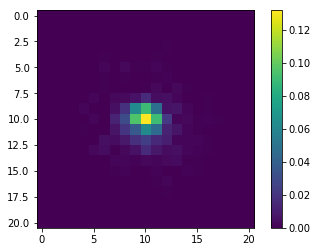

index 107, min values 0.000000


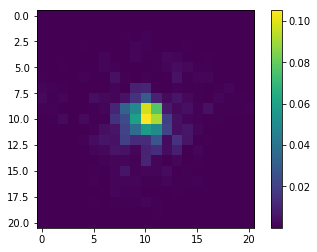

index 108, min values 0.000000


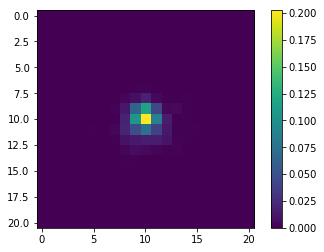

index 109, min values 0.000000


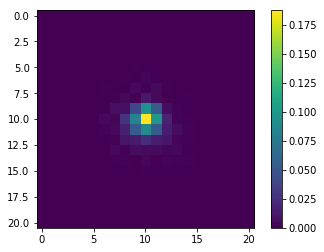

index 110, min values 0.000000


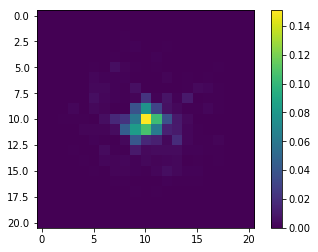

index 111, min values 0.000000


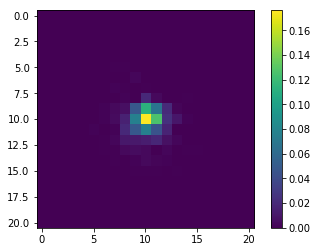

index 112, min values 0.000000


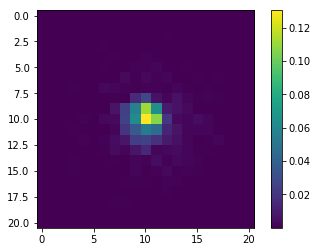

index 113, min values 0.000000


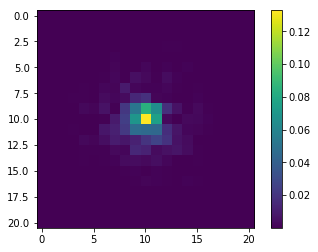

index 114, min values 0.000000


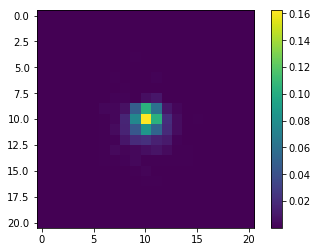

index 115, min values 0.000000


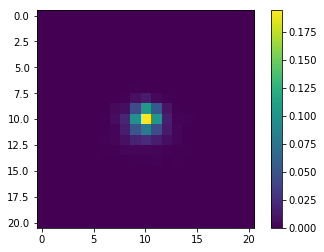

index 116, min values 0.000000


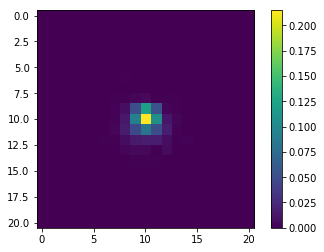

index 117, min values 0.000000


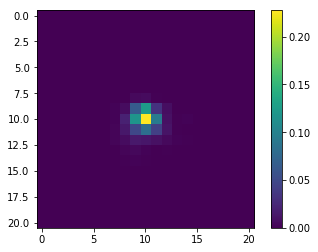

index 118, min values 0.000000


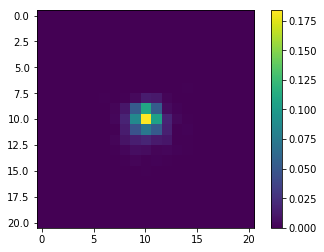

index 119, min values 0.000000


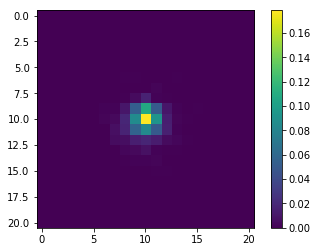

index 120, min values 0.000000


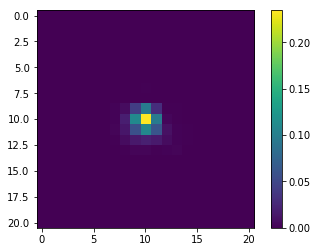

index 121, min values 0.000000


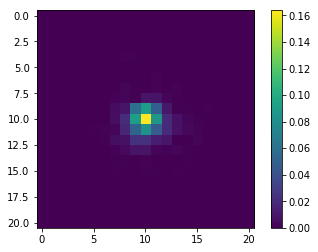

index 122, min values 0.000000


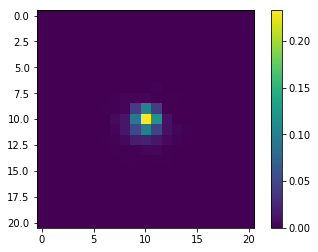

index 123, min values 0.000000


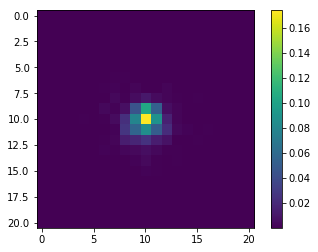

index 124, min values 0.000000


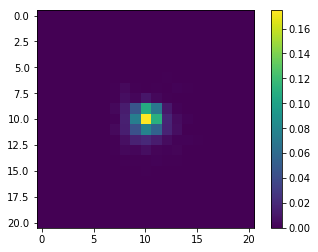

index 125, min values 0.000000


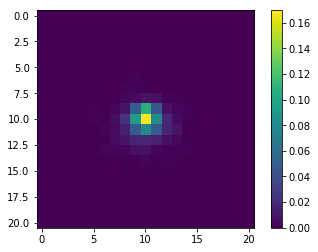

index 126, min values 0.000000


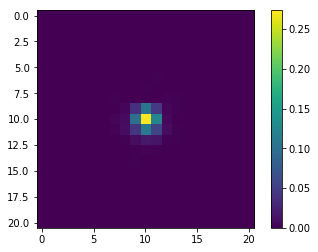

index 127, min values 0.000000


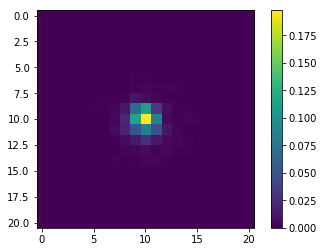

index 128, min values 0.000000


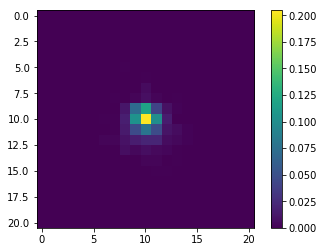

index 129, min values 0.000000


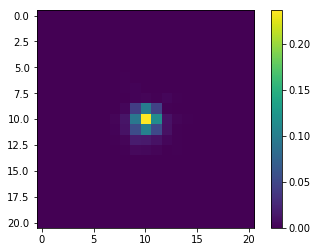

index 130, min values 0.000000


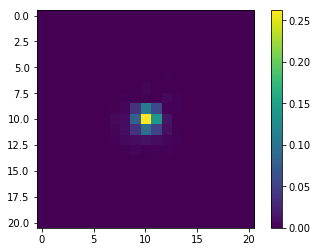

index 131, min values 0.000000


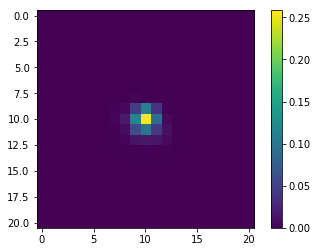

index 132, min values 0.000000


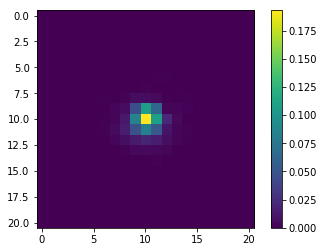

index 133, min values 0.000000


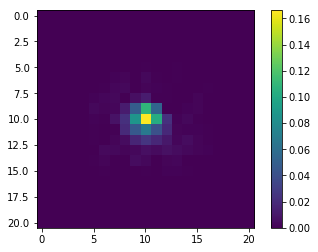

index 134, min values 0.000000


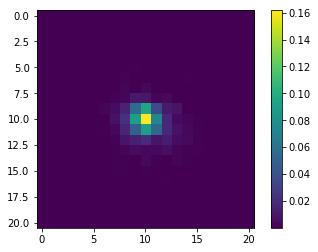

index 135, min values 0.000000


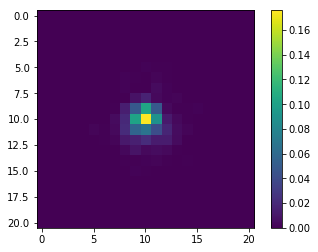

index 136, min values 0.000000


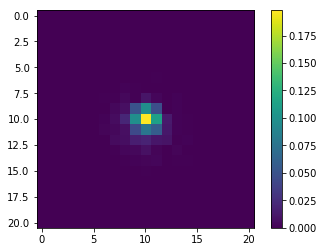

index 137, min values 0.000000


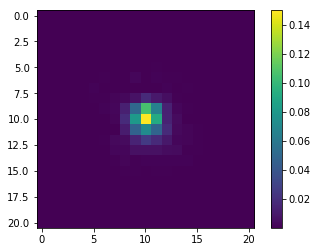

index 138, min values 0.000000


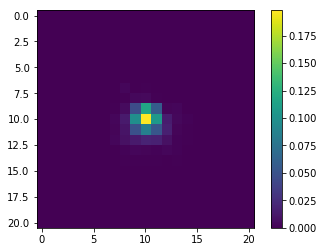

index 139, min values 0.000000


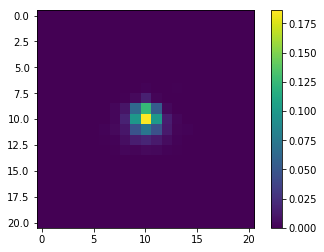

index 140, min values 0.000000


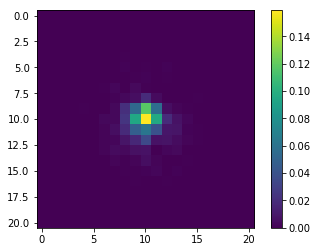

index 141, min values 0.000000


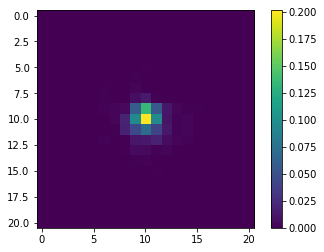

index 142, min values 0.000000


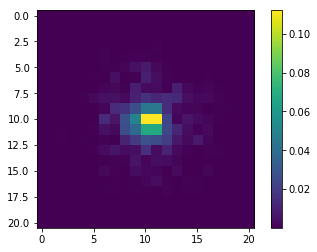

index 143, min values 0.000000


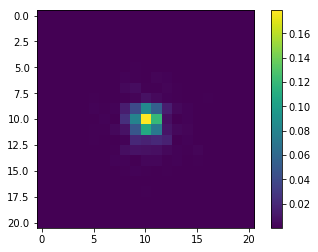

index 144, min values 0.000000


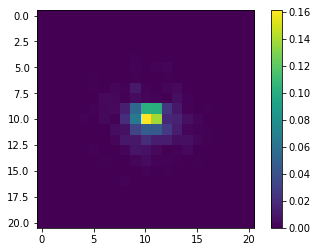

index 145, min values 0.000000


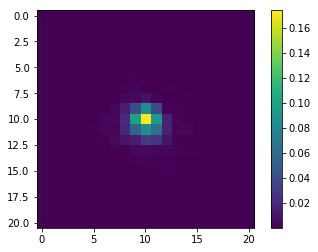

index 146, min values 0.000000


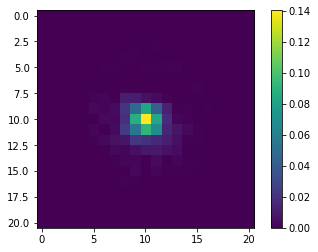

index 147, min values 0.000000


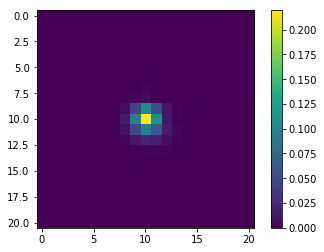

index 148, min values 0.000000


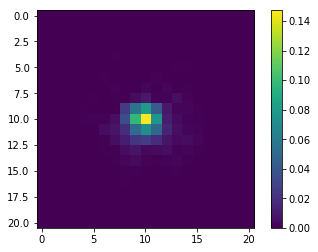

index 149, min values 0.000000


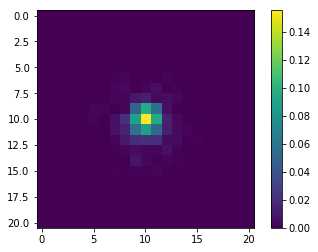

index 150, min values 0.000000


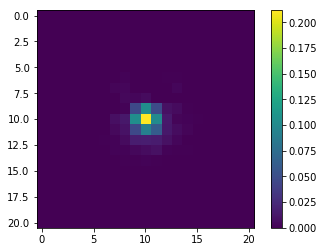

index 151, min values 0.000000


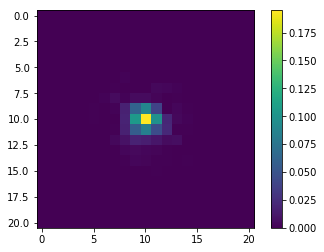

index 152, min values 0.000000


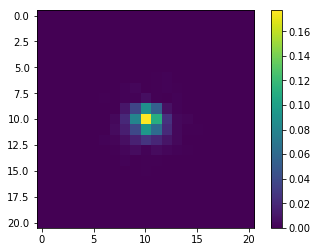

index 153, min values 0.000000


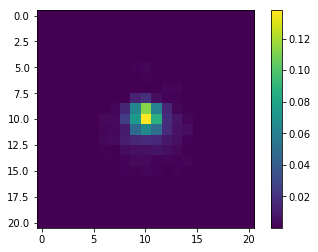

index 154, min values 0.000000


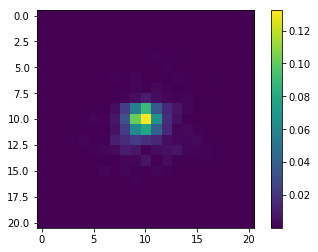

index 155, min values 0.000000


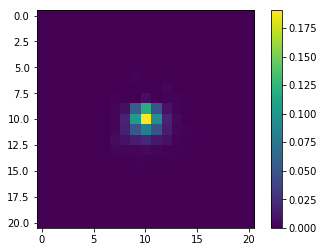

index 156, min values 0.000000


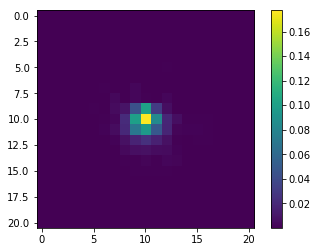

index 157, min values 0.000000


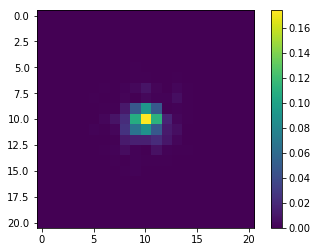

index 158, min values 0.000000


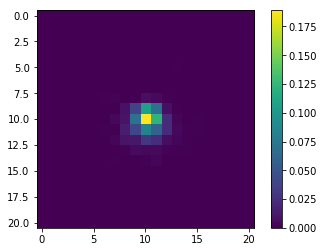

index 159, min values 0.000000


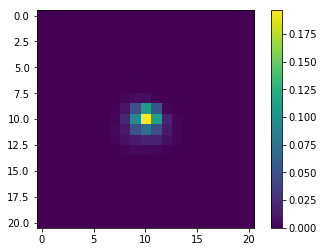

index 160, min values 0.000000


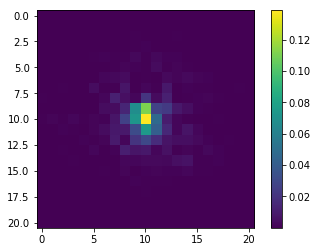

index 161, min values 0.000000


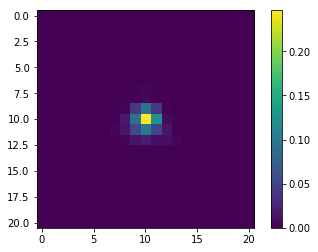

index 162, min values 0.000000


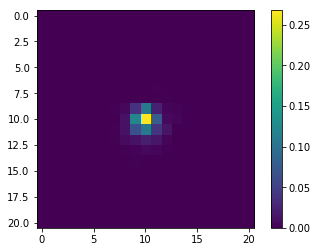

index 163, min values 0.000000


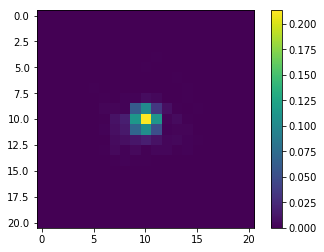

index 164, min values 0.000000


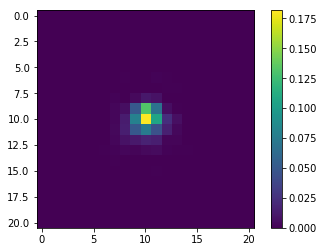

index 165, min values 0.000000


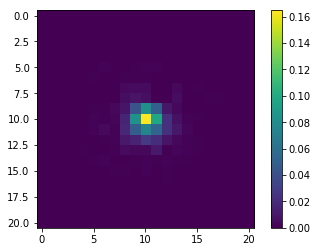

index 166, min values 0.000000


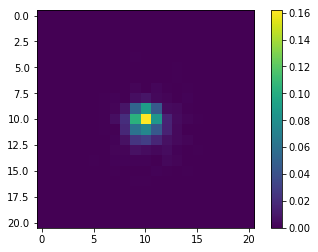

index 167, min values 0.000000


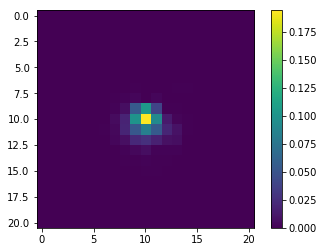

index 168, min values 0.000000


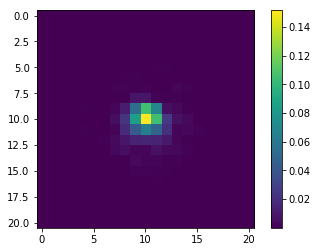

index 169, min values 0.000000


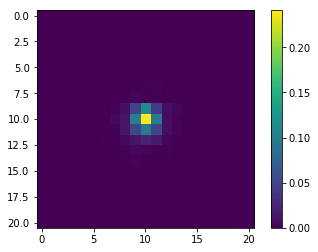

index 170, min values 0.000000


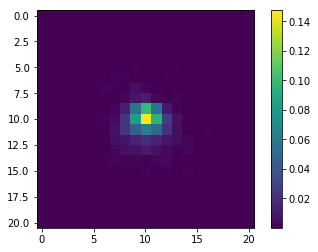

index 171, min values 0.000000


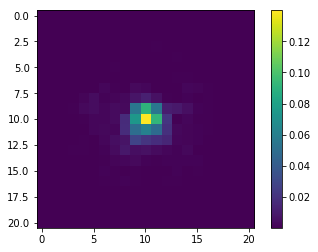

index 172, min values 0.000000


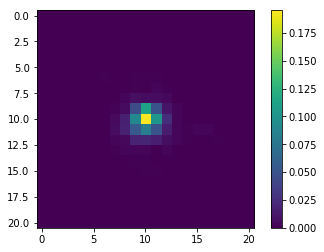

index 173, min values 0.000000


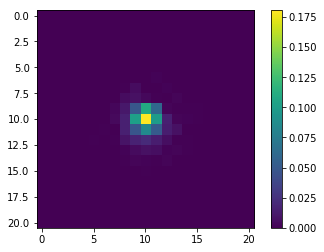

index 174, min values 0.000000


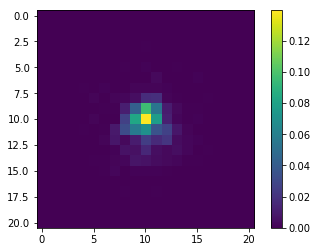

index 175, min values 0.000000


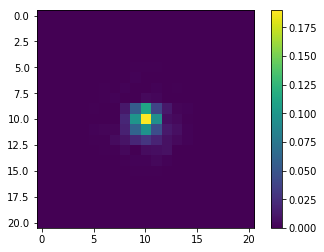

index 176, min values 0.000000


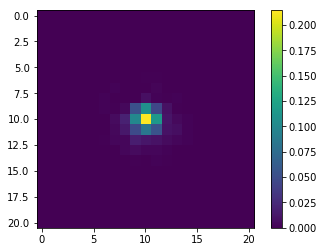

index 177, min values 0.000000


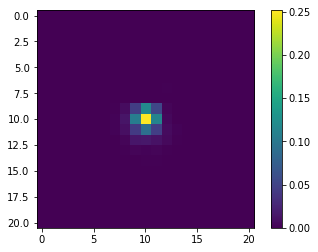

index 178, min values 0.000000


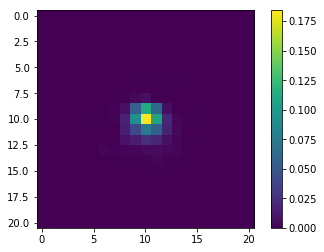

index 179, min values 0.000000


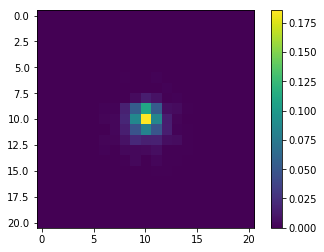

index 180, min values 0.000000


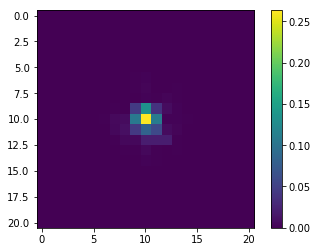

index 181, min values 0.000000


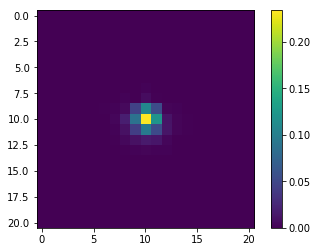

index 182, min values 0.000000


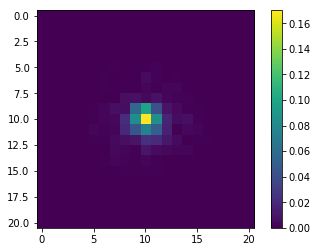

index 183, min values 0.000000


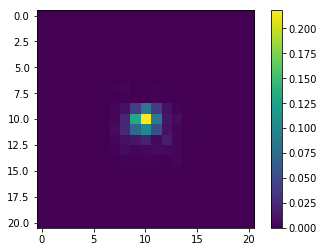

index 184, min values 0.000000


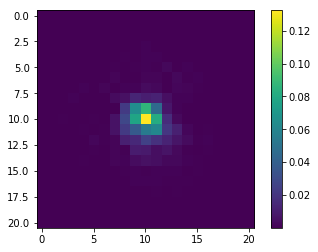

index 185, min values 0.000000


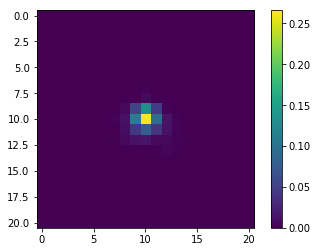

index 186, min values 0.000000


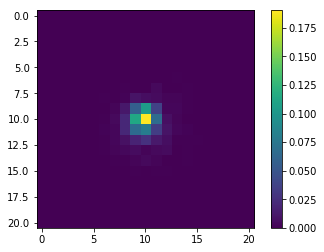

index 187, min values 0.000000


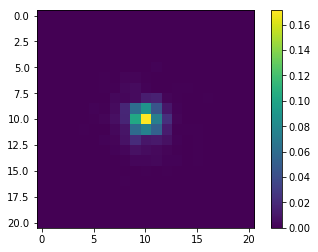

index 188, min values 0.000000


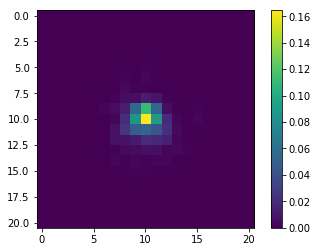

index 189, min values 0.000000


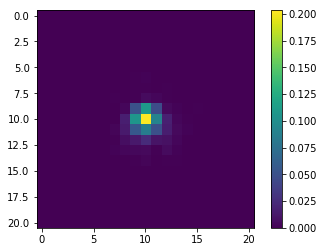

index 190, min values 0.000000


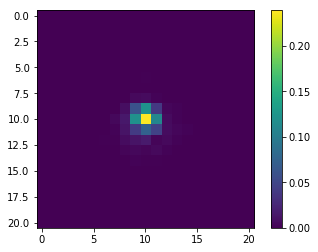

index 191, min values 0.000000


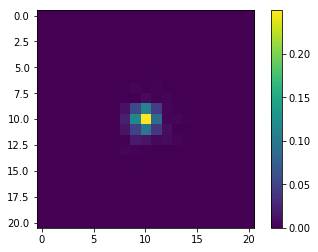

index 192, min values 0.000000


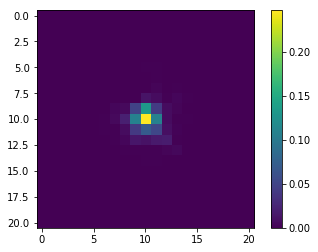

index 193, min values 0.000000


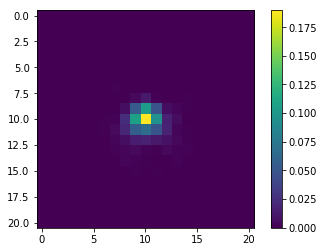

index 194, min values 0.000000


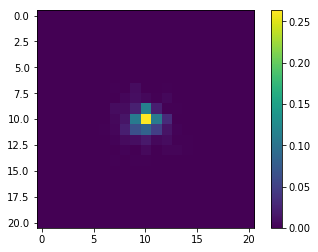

index 195, min values 0.000000


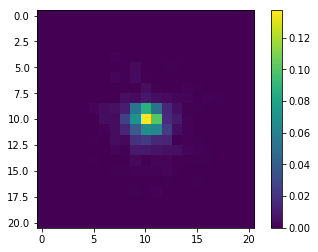

index 196, min values 0.000000


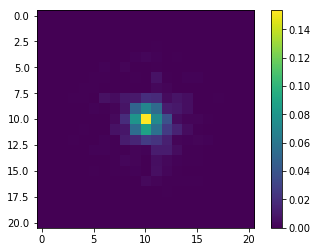

index 197, min values 0.000000


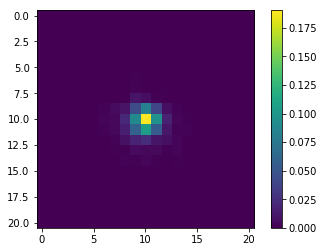

index 198, min values 0.000000


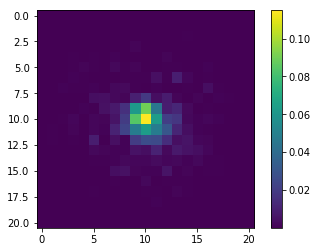

index 199, min values 0.000000


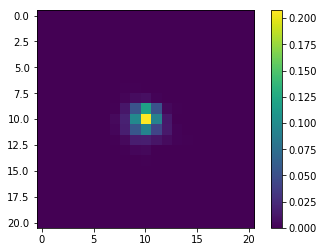

index 200, min values 0.000000


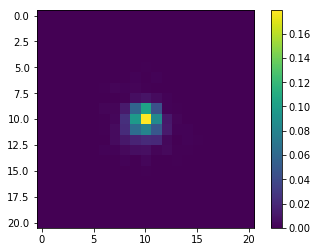

index 201, min values 0.000000


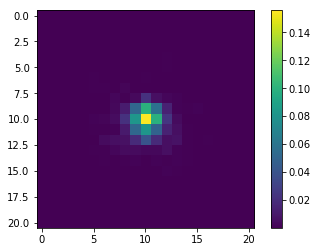

index 202, min values 0.000000


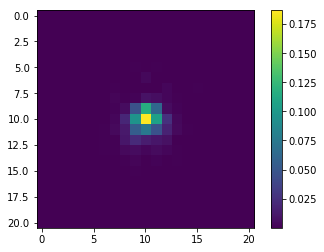

index 203, min values 0.000000


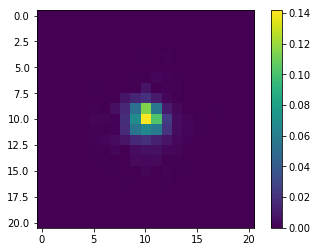

index 204, min values 0.000000


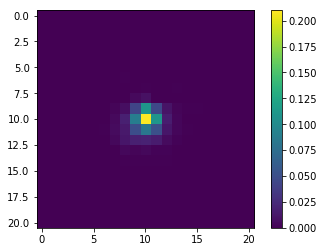

index 205, min values 0.000000


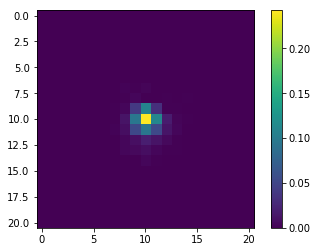

index 206, min values 0.000000


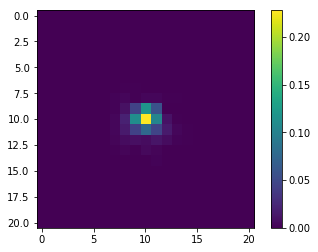

index 207, min values 0.000000


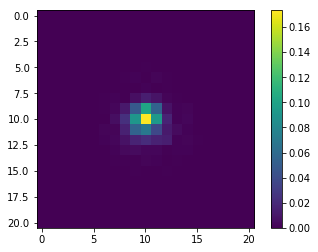

index 208, min values 0.000000


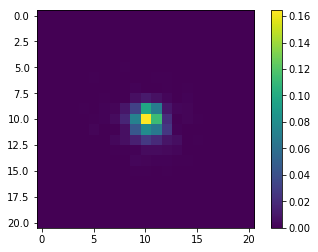

index 209, min values 0.000000


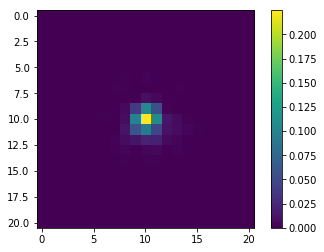

index 210, min values 0.000000


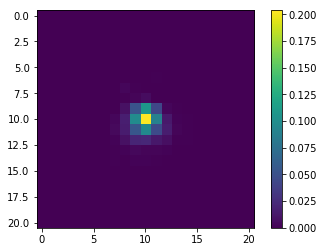

index 211, min values 0.000000


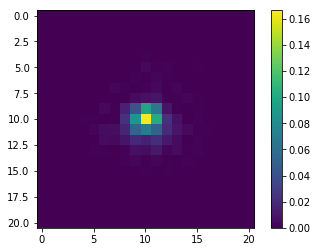

index 212, min values 0.000000


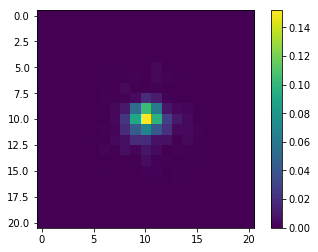

index 213, min values 0.000000


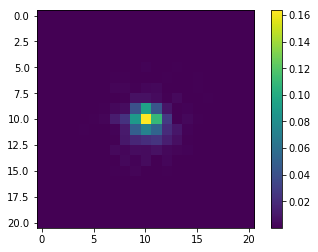

index 214, min values 0.000000


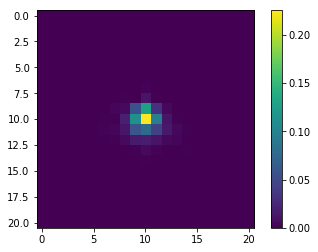

index 215, min values 0.000000


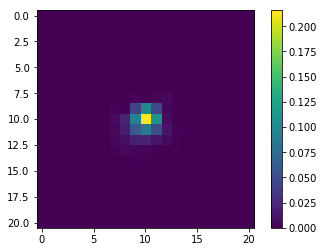

(21, 21, 216)

In [115]:

    
for i in range(psfs.shape[-1]):
    print('index %i, min values %f' % (i, np.min(psfs[...,i])))
    plt.imshow(psfs[...,i])
    plt.colorbar()
    plt.show()
psfs.shape
psfs.shape